In [13]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg
import os
import json

# load demand data
# DATA_NAME = 'ndf50_mldat6e8_university'
DATA_NAME = 'university_chancap500_numchans1_mldat2e6_bidirectional'
path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/{}_benchmark_data.json'.format(DATA_NAME)
benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time to load data from /home/zciccwf/phd_project/projects/trafpy/trafpy/../data/benchmark_data/university_chancap500_numchans1_mldat2e6_bidirectional_benchmark_data_v54.json: 3.304804563522339 s


In [14]:
%autoreload

# organise into list of demand_data dicts
benchmarks = list(benchmark_data.keys())
demand_data_list = []
loads = []
for benchmark in benchmarks:
    for load in benchmark_data[benchmark]:
        for repeat in benchmark_data[benchmark][load]:
            demand_data = benchmark_data[benchmark][load][repeat]
            demand_data_list.append(demand_data)
            loads.append(load)
num_sets_of_demand_data = len(demand_data_list)
print('Number of sets of demand data: {}'.format(num_sets_of_demand_data))
print(demand_data_list[0])

Number of sets of demand data: 9
{'flow_id': ['flow_2221', 'flow_1970', 'flow_1243', 'flow_2444', 'flow_3076', 'flow_1147', 'flow_1493', 'flow_2662', 'flow_580', 'flow_69', 'flow_684', 'flow_464', 'flow_2733', 'flow_955', 'flow_412', 'flow_2660', 'flow_2876', 'flow_1647', 'flow_574', 'flow_1054', 'flow_2754', 'flow_1190', 'flow_2807', 'flow_245', 'flow_189', 'flow_2373', 'flow_3142', 'flow_191', 'flow_1208', 'flow_9', 'flow_2006', 'flow_2138', 'flow_2231', 'flow_26', 'flow_1656', 'flow_2588', 'flow_1157', 'flow_21', 'flow_2529', 'flow_96', 'flow_2892', 'flow_1451', 'flow_2580', 'flow_2268', 'flow_2412', 'flow_722', 'flow_2110', 'flow_2578', 'flow_2884', 'flow_1514', 'flow_358', 'flow_1117', 'flow_230', 'flow_751', 'flow_1654', 'flow_534', 'flow_563', 'flow_727', 'flow_2327', 'flow_1382', 'flow_1363', 'flow_396', 'flow_3150', 'flow_1808', 'flow_1408', 'flow_467', 'flow_260', 'flow_1942', 'flow_1574', 'flow_3213', 'flow_340', 'flow_1988', 'flow_1961', 'flow_2641', 'flow_1221', 'flow_1072

+----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------------+
|    | Name   |   Flows |   1st |        Last |    Duration |        Info |   Load |   Smallest |     Largest |
|----+--------+---------+-------+-------------+-------------+-------------+--------+------------+-------------|
|  0 | demand |   14850 |     0 | 2.74225e+06 | 2.74225e+06 | 8.22675e+08 |    600 |          1 | 1.7019e+07  |
|  1 | demand |   28050 |     0 | 2.50443e+06 | 2.50443e+06 | 1.50266e+09 |   1200 |          1 | 1.05379e+07 |
|  2 | demand |   54450 |     0 | 3.33969e+06 | 3.33969e+06 | 3.00572e+09 |   1800 |          1 | 1.05379e+07 |
|  3 | demand |  107250 |     0 | 3.67306e+06 | 3.67306e+06 | 4.40768e+09 |   2400 |          1 | 6.09338e+06 |
|  4 | demand |  107250 |     0 | 2.96996e+06 | 2.96996e+06 | 4.45494e+09 |   3000 |          1 | 9.48487e+06 |
|  5 | demand |  107250 |     0 | 2.80467e+06 | 2.80467e+06 | 5.0484e+09  |   3600 |          1 | 6.0933

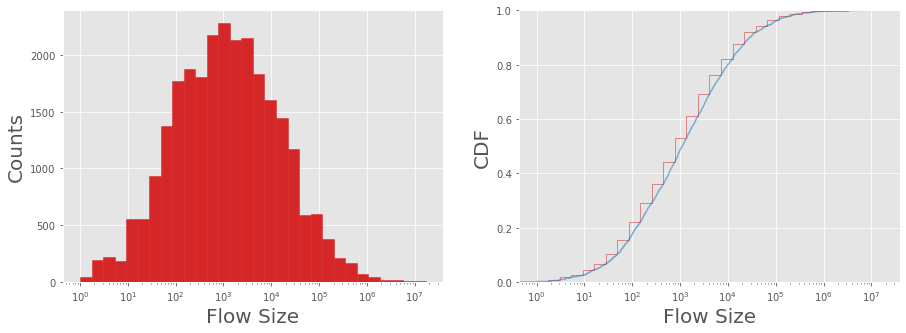

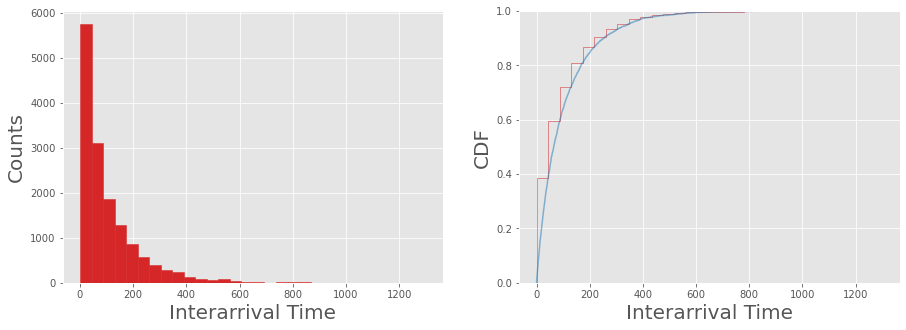

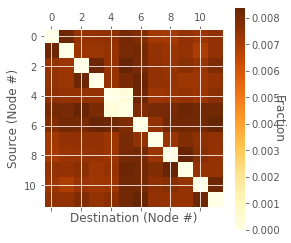

<Figure size 432x288 with 0 Axes>

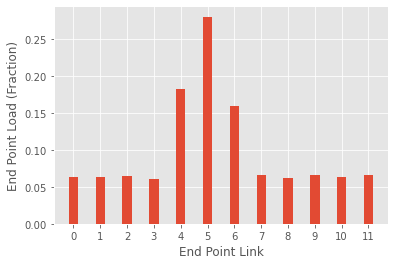

<Figure size 432x288 with 0 Axes>

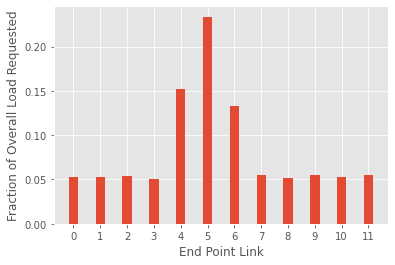

<Figure size 432x288 with 0 Axes>

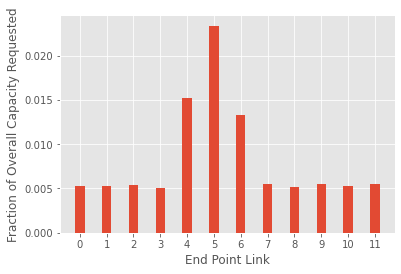

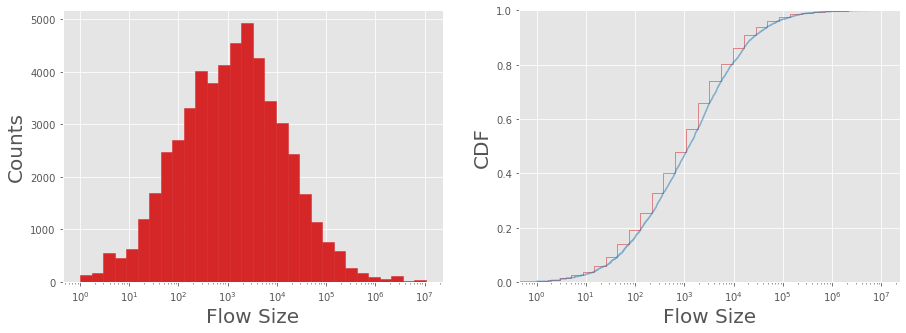

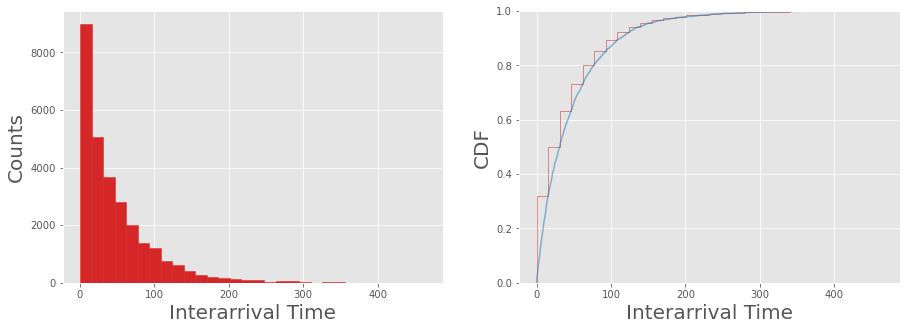

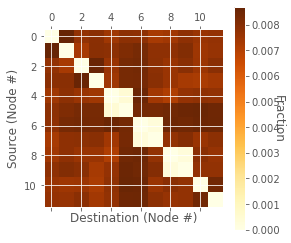

<Figure size 432x288 with 0 Axes>

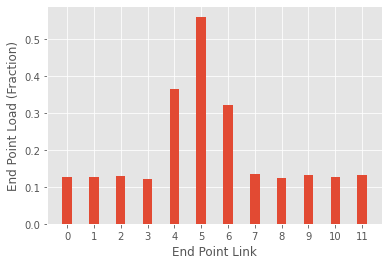

<Figure size 432x288 with 0 Axes>

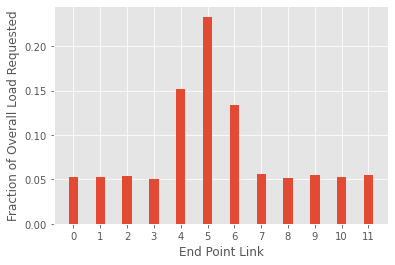

<Figure size 432x288 with 0 Axes>

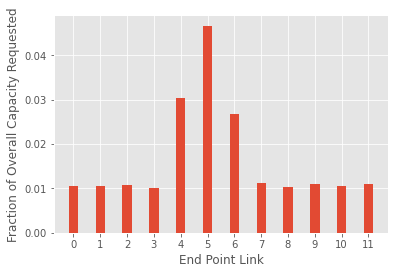

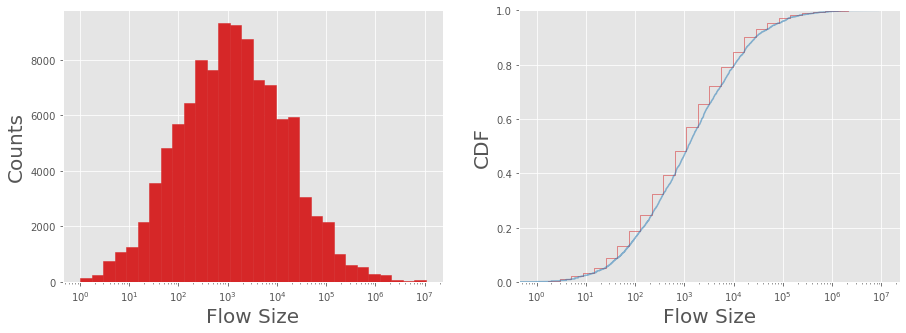

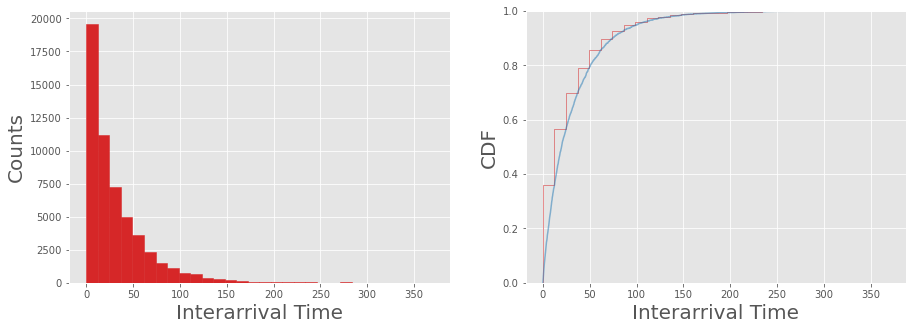

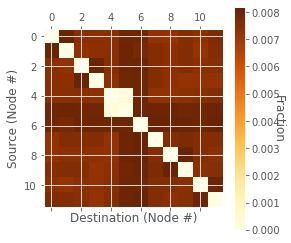

<Figure size 432x288 with 0 Axes>

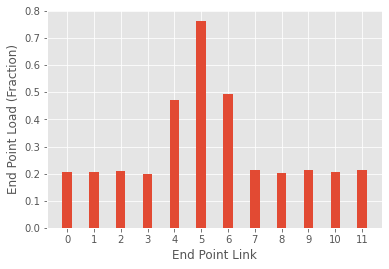

<Figure size 432x288 with 0 Axes>

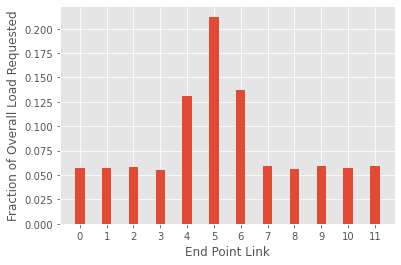

<Figure size 432x288 with 0 Axes>

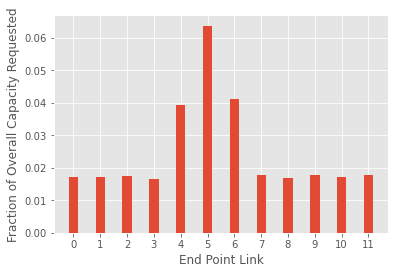

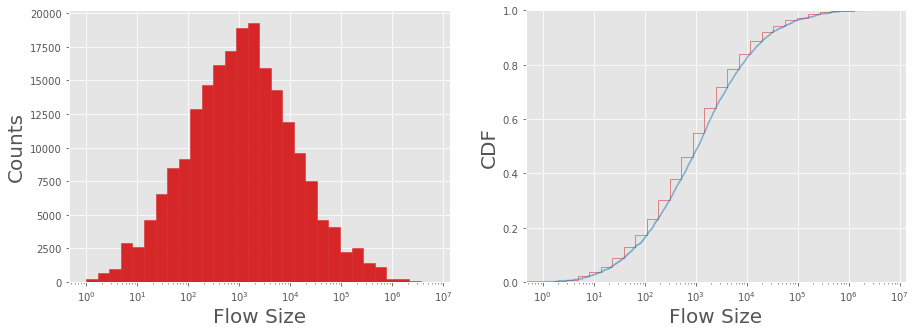

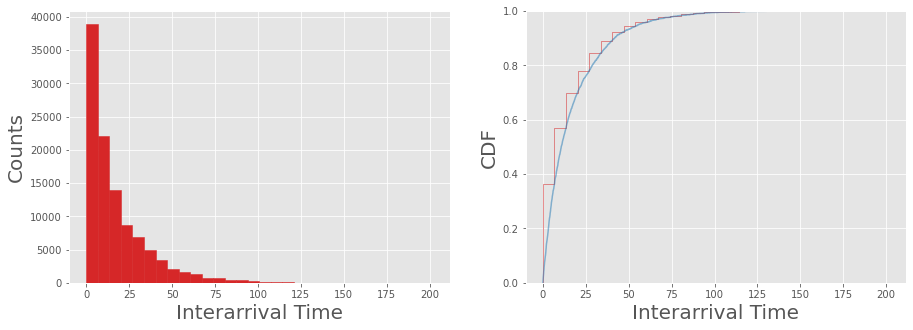

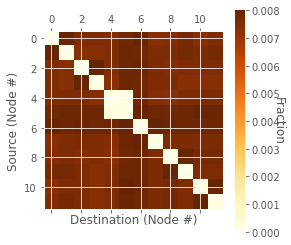

<Figure size 432x288 with 0 Axes>

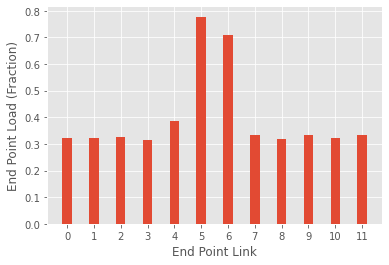

<Figure size 432x288 with 0 Axes>

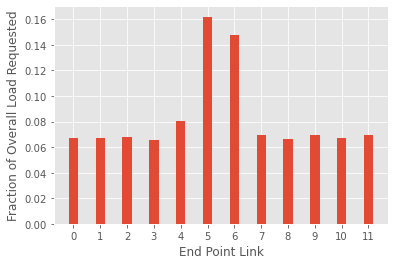

<Figure size 432x288 with 0 Axes>

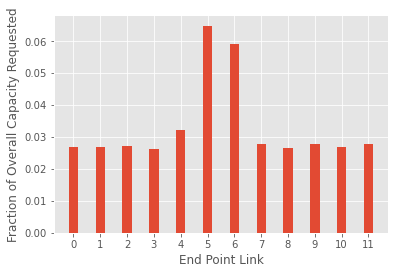

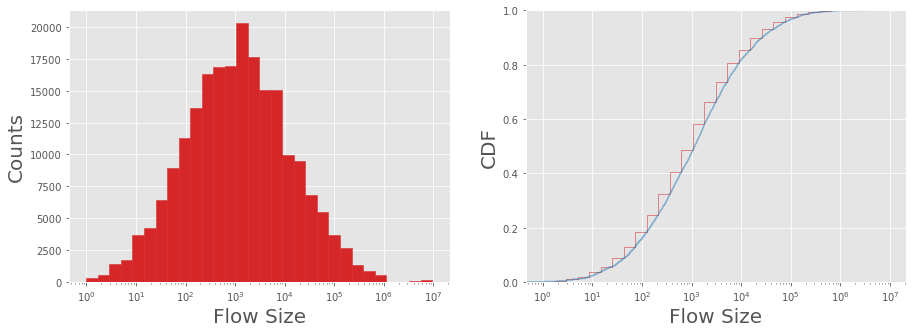

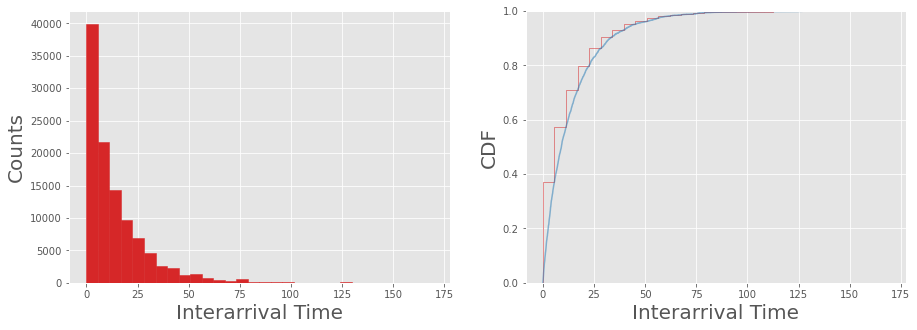

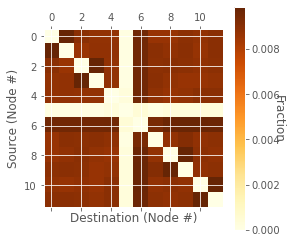

<Figure size 432x288 with 0 Axes>

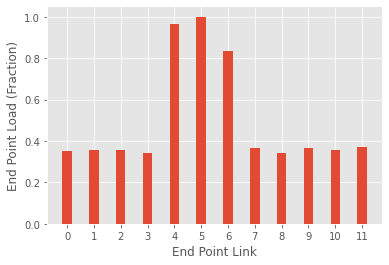

<Figure size 432x288 with 0 Axes>

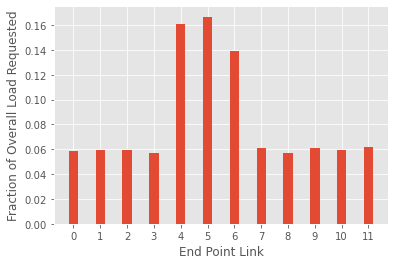

<Figure size 432x288 with 0 Axes>

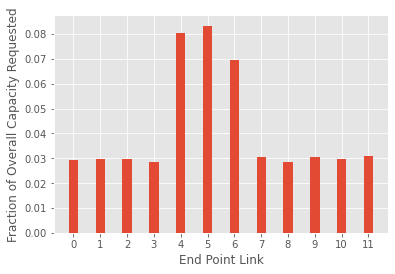

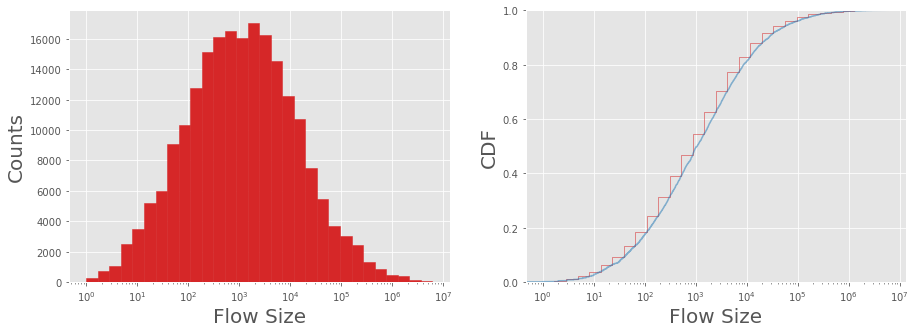

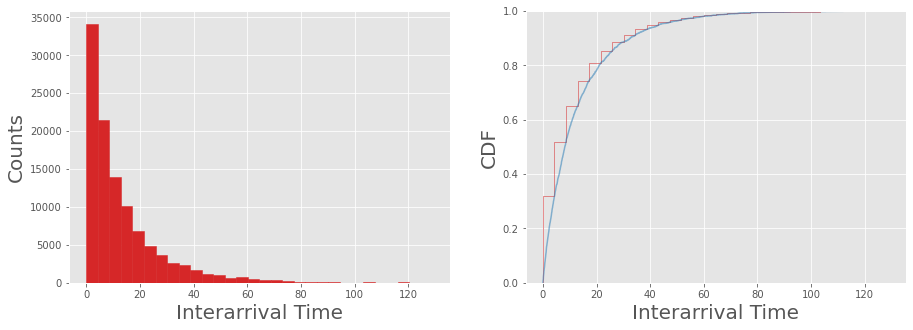

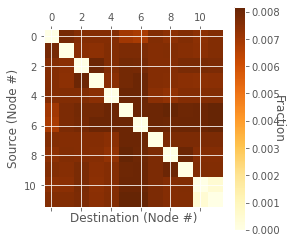

<Figure size 432x288 with 0 Axes>

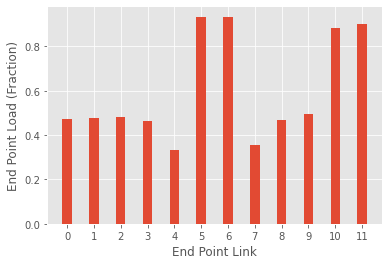

<Figure size 432x288 with 0 Axes>

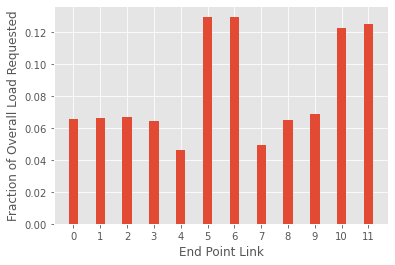

<Figure size 432x288 with 0 Axes>

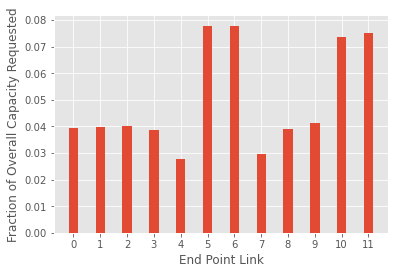

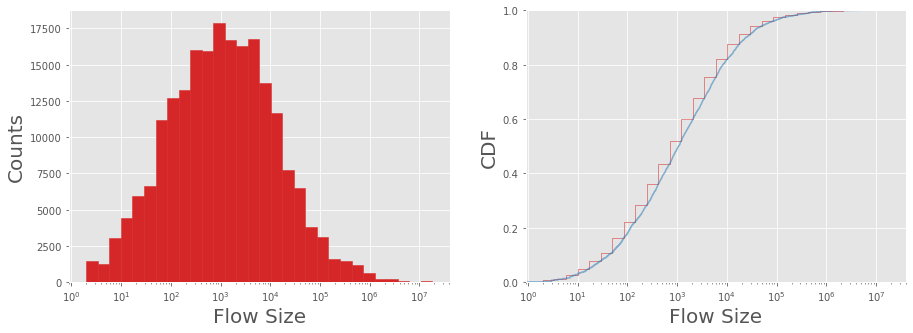

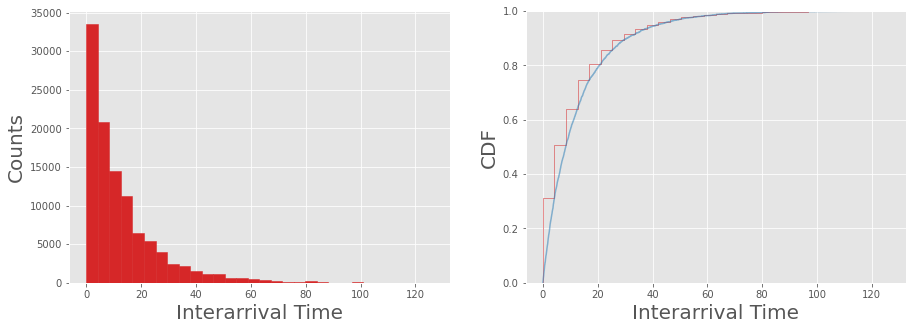

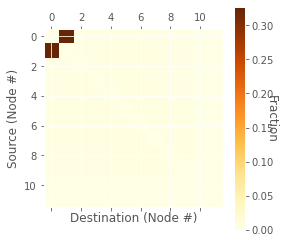

<Figure size 432x288 with 0 Axes>

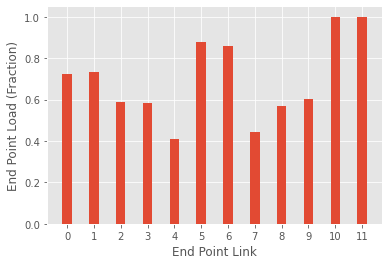

<Figure size 432x288 with 0 Axes>

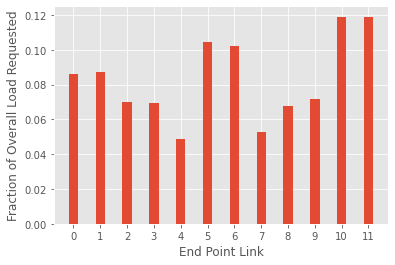

<Figure size 432x288 with 0 Axes>

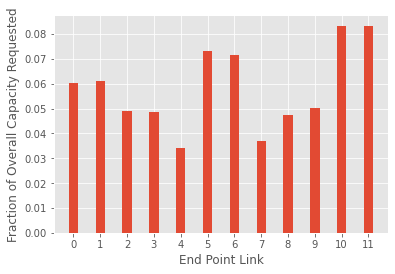

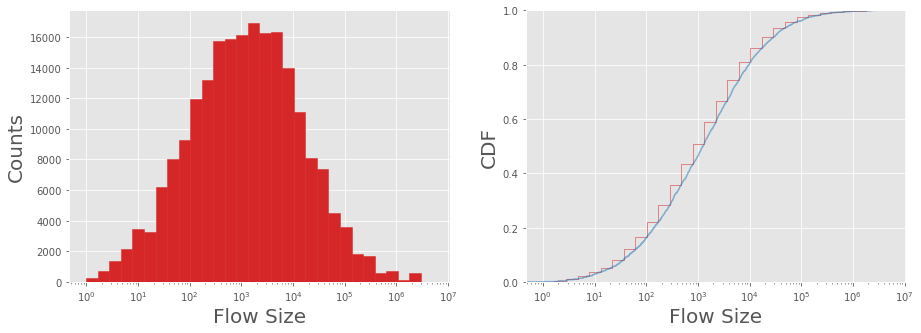

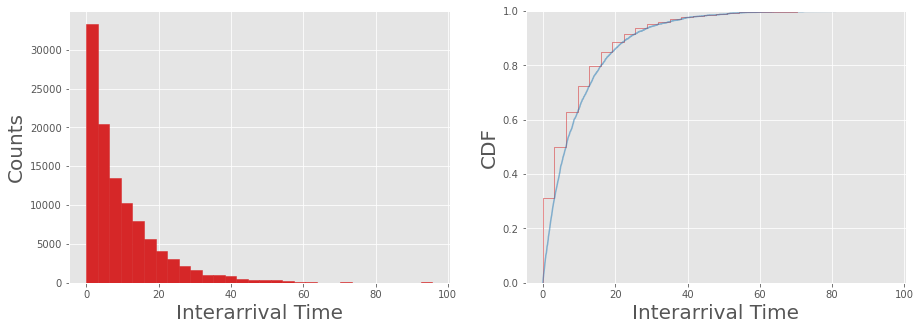

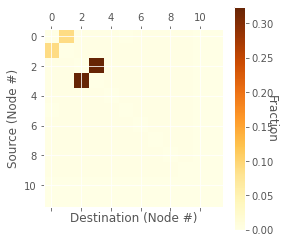

<Figure size 432x288 with 0 Axes>

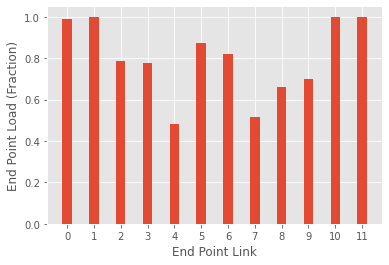

<Figure size 432x288 with 0 Axes>

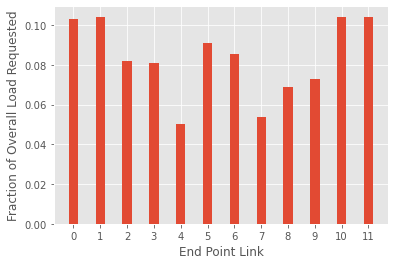

<Figure size 432x288 with 0 Axes>

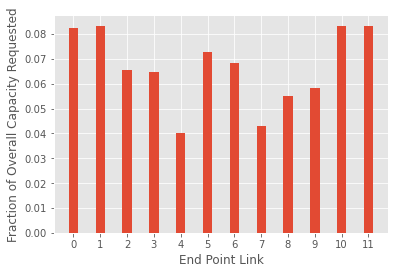

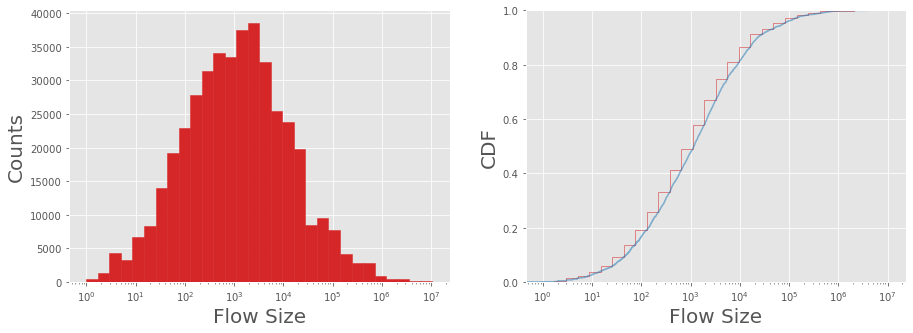

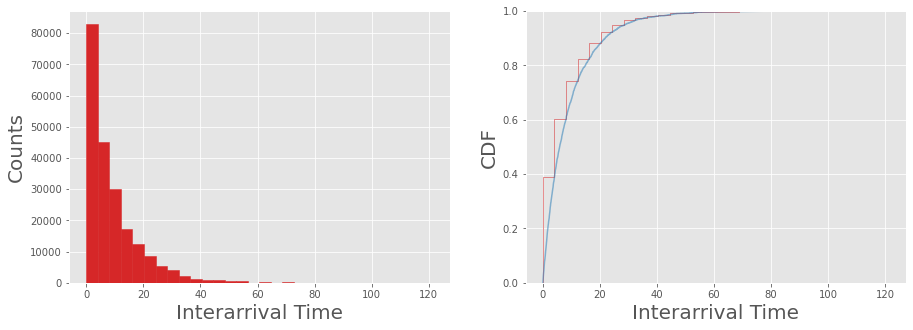

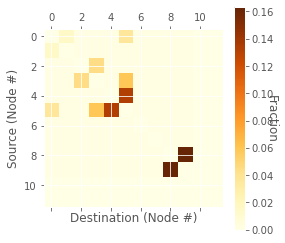

<Figure size 432x288 with 0 Axes>

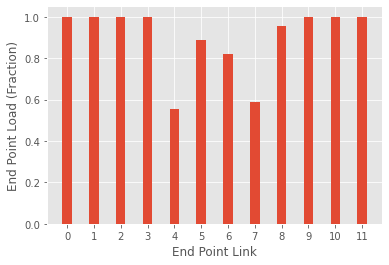

<Figure size 432x288 with 0 Axes>

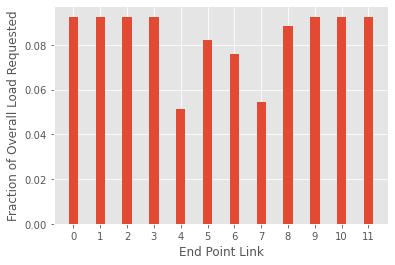

<Figure size 432x288 with 0 Axes>

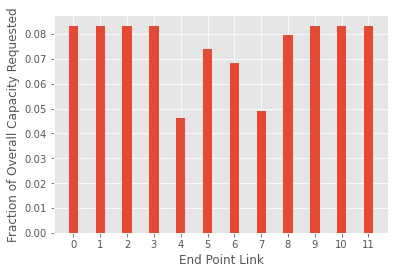

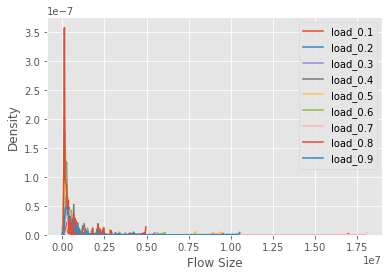

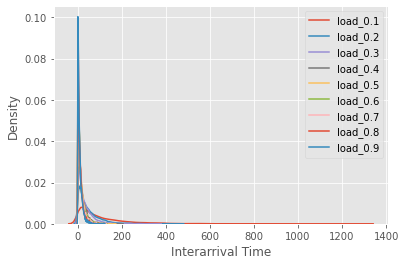

In [15]:
%autoreload
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # disable warnings
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# for plotting
net = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=40000, edge_to_agg_channel_capacity=40000, agg_to_core_channel_capacity=40000)
slot_size = 1e6

# create demand objects and print analysis summary
demands = []
for demand_data, load in zip(demand_data_list, loads):
    demand = Demand(demand_data, net.graph['endpoints'])
    demand.name = 'load_{}'.format(load) # name for multi-plot jjlegend(s)
    demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, num_bins=30)
    plotter.plot_interarrival_time_dist(logscale=False, num_bins=30)
    plotter.plot_node_dist(eps=['server_{}'.format(i) for i in range(12)])
    plotter.plot_node_load_dists(eps=['server_{}'.format(i) for i in range(12)], ep_link_bandwidth=500)
#     plotter.plot_link_loads_vs_time(net, slot_size, demand, mean_period='all')
analyser = DemandsAnalyser(*demands)
analyser.compute_metrics(print_summary=True)

plotters = DemandsPlotter(*demands)
_ = plotters.plot_flow_size_dists(logscale=False)
_ = plotters.plot_interarrival_time_dists(logscale=False)

In [ ]:
_ = plotters.plot_link_loads_vs_time_for_different_loads(logscale=False)

In [ ]:
%autoreload
print('Keys of first demand data set:\n{}'.format(demand_data_list[0].keys()))
# print('\nStructure of first demand data set:\n{}'.format(demand_data_list[0]))

In [ ]:
%autoreload
for benchmark in benchmarks:
    print(benchmark_data[benchmark].keys())
    for load in list(benchmark_data[benchmark].keys()):
        for repeat in benchmark_data[benchmark][load]:
            print('benchmark: {} | load: {} | repeat: {}'.format(benchmark,load,repeat))

In [ ]:
%autoreload
from trafpy.generator import Demand
import sys
import json

demand = Demand(demand_data_list[-1])
for SLOT_SIZE in [1e4]:
    slots_dict = demand.get_slots_dict(SLOT_SIZE, print_info=True)

In [ ]:
slots_dict[0]